
# Knowledge Graphs and Semantic Technologies -- ML4KG Tutorial


Import libraries

In [1]:
# you need to install pykeen beforehand, see https://pykeen.readthedocs.io/en/stable/installation.html 
import os
import numpy as np
import pandas as pd
import pykeen
import seaborn

# 1. Dataset exploration


PyKeen comes with its own datasets that can be used directly in a pipeline.
Below we import it so that we can explore it later.

In [2]:
from pykeen.datasets import Nations

/Users/thezamp/miniconda3/envs/krw/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


However, we want to be able tfo work with our own datasets as well, so we etch the online GoT dataset as well.

In [19]:
import requests
from pykeen import triples
from pykeen.datasets.nations import NATIONS_TRAIN_PATH
url = 'https://ampligraph.s3-eu-west-1.amazonaws.com/datasets/GoT.csv'
open('GoT.csv', 'wb').write(requests.get(url).content)

# Format that can be read by a pd.from_csv should also be able to be read here, but the delimiter needs to be adjusted
# PyKEEN uses tabs as defaults
got = triples.TriplesFactory.from_path('GoT.csv',load_triples_kwargs=dict(delimiter=','))
got_triples = got.triples
got_triples[:5,]

array([['Abelar Hightower', 'ALLIED_WITH',
        'House Hightower of the Hightower'],
       ['Acorn Hall', 'SEAT_OF', 'House Smallwood of Acorn Hall'],
       ['Addam Frey', 'ALLIED_WITH', 'House Frey of the Crossing'],
       ['Addam Marbrand', 'ALLIED_WITH', 'House Marbrand of Ashemark'],
       ['Addam Osgrey', 'ALLIED_WITH', 'House Osgrey of Standfast']],
      dtype='<U44')

### Exercise 1

List the unique subject and object entities found in the dataset. Then list all of the relationships that link the entities (note that some entities are not linked). Create an RDF version of the dataset, using your own namespaces, and save is as a ttl file. 

Using SPARQL, answer the following questions : 
1. How many instances per class? Use ORDER BY to show the most popular class
2. What is the most common relation per each class?

In [4]:
### your code here

# 2. Defining train and test datasets


As is typical in machine learning, we need to split our dataset into training and test (and sometimes validation) datasets.

What differs from the standard method of randomly sampling N points to make up our test set, is that our data points are two entities linked by some relationship, and we need to take care to ensure that all entities are represented in train and test sets by at least one triple.

To accomplish this, PyKEEN provides the <b>pykeen.triples.TriplesFactory.split()</b> function, which defaults to an 80/20 split. It is also by default stratified, to ensure that the distribution of the test set corresponds to that of the training set. If you want to use early stopping, you will also need a validation set. The function takes a list of percentages as argument: if you want a 95/5 split you give it <b>[0.95,0.05]</b> as argument, if you want 90/5/5 (which would include a validation set as well) you give it <b>[0.9,0.05,0.05]</b> as argument and it will return 3 datasets.

For sake of example, we will create a small test size that includes only 5% of triples. 

In [26]:
# got_training, got_testing = got.split()
got_training, got_testing = got.split([0.95,0.05])

print('Train set size: ', got_training.triples.shape)
print('Test set size: ', got_testing.triples.shape)


INFO:pykeen.triples.splitting:done splitting triples to groups of sizes [1003, 159]


Train set size:  (3016, 3)
Test set size:  (159, 3)


### Exercise 2

Create three train-test sets of different sizes from the GoT data. Give them different names. Make sure the test set is not too big when compared to the training set (test set should be max 15% of the total dataset).

In [6]:
### your code here

# 3. Training and testing the model

PyKEEN has implemented several Knoweldge Graph Embedding models (TransE, ComplEx, DistMult, HolE, etc.). We will use the ComplEx model with default values for this tutorial.

You can find the list of all implemented models in the documentation: https://pykeen.readthedocs.io/en/stable/reference/models.html

Importing a model and instantiate it:
There are two ways to import and use a model, both are shown below and don't give different results but not importing the model before hand might cause the automatic importing to be slower, especially if you plan to use the same model multiple times.

No cuda devices were available. The model runs on CPU
Training epochs on cpu: 100%|██████████| 5/5 [00:00<00:00,  6.05epoch/s, loss=15.5, prev_loss=16]  
Evaluating on cpu:   0%|          | 0.00/80.0 [00:00<?, ?triple/s]WARNING:torch_max_mem.api:Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).
Evaluating on cpu: 100%|██████████| 80.0/80.0 [00:00<00:00, 4.45ktriple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.02s seconds
/Users/thezamp/miniconda3/envs/krw/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/thezamp/miniconda3/envs/krw/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is depreca

<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

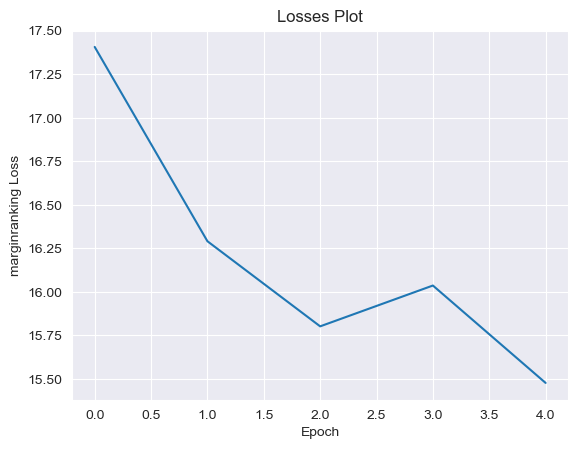

In [7]:
# wee need the pipeline to run a model, so it is simpler to import it directly.
# Pykeen lets you train a model with the minimal amount of custom parameters

from pykeen.pipeline import pipeline

# here we don't import the model, but let PyKEEN do the importing.
pipeline_result_simple = pipeline(
    random_seed=0,
    model='ComplEx',
    training=got_training,
    testing=got_testing,
)
pipeline_result_simple.plot_losses()

INFO:pykeen.pipeline.api:Using device: None
Training epochs on cpu: 100%|██████████| 5/5 [00:00<00:00,  6.88epoch/s, loss=15.5, prev_loss=16]  
Evaluating on cpu:   0%|          | 0.00/80.0 [00:00<?, ?triple/s]WARNING:torch_max_mem.api:Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).
Evaluating on cpu: 100%|██████████| 80.0/80.0 [00:00<00:00, 5.10ktriple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.02s seconds
/Users/thezamp/miniconda3/envs/krw/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/thezamp/miniconda3/envs/krw/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and wi

<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

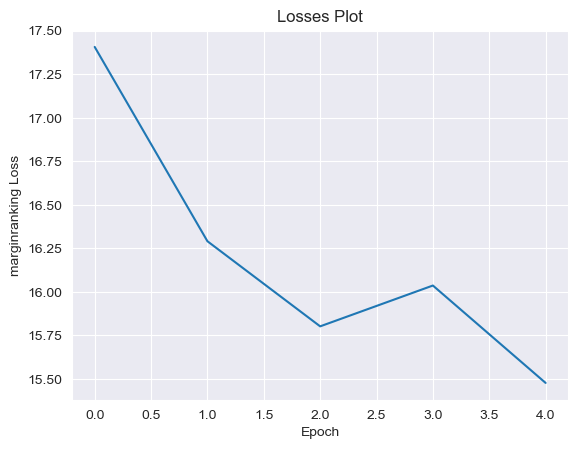

In [8]:
# here we import the model and use it directly.
from pykeen.models import ComplEx

pipeline_result_imported = pipeline(
    random_seed=0,
    model=ComplEx,
    training=got_training,
    testing=got_testing,
)
pipeline_result_imported.plot_losses()

You can retrieve different metrics from the results. Here we retrieve the mean reciprocal rank (MRR). The result is the same for both the simple and imported model, because we used the same random seed (0).

In [9]:
print(pipeline_result_imported.get_metric('mrr'))
print(pipeline_result_simple.get_metric('mrr'))

0.3374660313129425
0.3374660313129425


In [11]:
# but to get a better performing model, you want to set different things
pipeline_result = pipeline(
    random_seed=0,
    model='ComplEx',
    training=got_training,
    testing=got_testing,
    epochs=200,
    dimensions=150,
    optimizer='adam',
    optimizer_kwargs={'lr':1e-3},
    loss='pairwisehinge', 
    regularizer='LP', 
    regularizer_kwargs={'p':3, 'weight':1e-5}, 
)
print(pipeline_result.get_metric('mrr'))

INFO:pykeen.pipeline.api:Using device: None
Training epochs on cpu: 100%|██████████| 200/200 [00:27<00:00,  7.35epoch/s, loss=2.04, prev_loss=2.14]
Evaluating on cpu:   0%|          | 0.00/80.0 [00:00<?, ?triple/s]WARNING:torch_max_mem.api:Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).
Evaluating on cpu: 100%|██████████| 80.0/80.0 [00:00<00:00, 2.58ktriple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.06s seconds


0.34232959151268005


Understanding the parameters:

- dimensions : the dimensionality of the embedding space
- negative_sampler : the negative samplic strategy, here set to default (not used in arguments).
- batch_size : the number of batches in which the training set is split during the training loop. If you are having into low memory issues than settings this to a higher number may help.
- epochs : the number of epochs to train the model for.
- optimizer : the Adam optimizer, with a learning rate of $1e-3$ set via the <i>optimizer_kwarg</i>.
- loss : pairwise loss, with a margin of $0.5$ set via the <i>loss_kwarg</i>.
- regularizer :  regularization with $p=2$, i.e. $l_2$ regularization. $\lambda$ = $1e-5$, set via the <i>regularizer_kwarg</i>.

### Filtering Negatives

To ensure our model can be trained and evaluated correctly, we need to define a filter to ensure that no negative statements generated by the corruption procedure are actually positives. This is simply done by concatenating train and test sets. When negative triples are generated by the corruption strategy, we can check that they aren't actually true statements.

With PyKEEN this is made very easy, and can simply be passed as an argument.

In [96]:
pipeline_result = pipeline(
    model='ComplEx',
    training=got_training,
    testing=got_testing,
    epochs=200,
    dimensions=150,
    optimizer='adam',
    optimizer_kwargs={'lr':1e-3},
    loss='pairwisehinge', 
    regularizer='LP', 
    regularizer_kwargs={'p':3, 'weight':1e-5}, 
    
    negative_sampler='basic',
    negative_sampler_kwargs=dict(
        filtered=True,
    )
)
print(pipeline_result.get_metric('mrr'))

INFO:pykeen.pipeline.api:Using device: None
Training epochs on cpu: 100%|██████████| 200/200 [00:38<00:00,  5.26epoch/s, loss=0.202, prev_loss=0.278]
Evaluating on cpu:   0%|          | 0.00/159 [00:00<?, ?triple/s]WARNING:torch_max_mem.api:Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).
Evaluating on cpu: 100%|██████████| 159/159 [00:00<00:00, 916triple/s] 
INFO:pykeen.evaluation.evaluator:Evaluation took 0.18s seconds


0.0025822946336120367


To save your learned model and also the results, we need to add checkpoints to the pipeline.
By adding training kwargs to the pipeline, the model will be automatically saved. By default, it saves the model after every epoch (checkpoint_frequency=0). You can also set the directory to which the models are saved, but by default they will end up in ~/.data/pykeen/checkpoints.

In [12]:
pipeline_result = pipeline(
    model='ComplEx',
    training=got_training,
    testing=got_testing,
    training_kwargs=dict(
        num_epochs=200,
        checkpoint_name='got_complex_checkpoint.pt',
        checkpoint_directory='checkpoint_dir/',
        checkpoint_frequency=20,
    ),
    dimensions=150,
    optimizer='adam',
    optimizer_kwargs={'lr':1e-3},
    loss='pairwisehinge', 
    regularizer='LP', 
    regularizer_kwargs={'p':3, 'weight':1e-5}, 
    negative_sampler='basic',
    negative_sampler_kwargs=dict(
        filtered=True,
    )
)

INFO:pykeen.pipeline.api:loaded random seed 242643974 from checkpoint.
INFO:pykeen.pipeline.api:Using device: None
INFO:pykeen.training.training_loop:=> loading checkpoint 'checkpoint_dir/got_complex_checkpoint.pt'
INFO:pykeen.training.training_loop:=> loaded checkpoint 'checkpoint_dir/got_complex_checkpoint.pt' stopped after having finished epoch 200
INFO:pykeen.stoppers.stopper:=> loading stopper summary dict from training loop checkpoint in 'checkpoint_dir/got_complex_checkpoint.pt'
INFO:pykeen.stoppers.stopper:=> loaded stopper summary dictionary from checkpoint in 'checkpoint_dir/got_complex_checkpoint.pt'
Training epochs on cuda:0: 100%|███████████████████████████████████████████████████████████| 200/200 [00:00<?, ?epoch/s]
INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=159.
Evaluating on cuda:0: 100%|███████████████████████████████████████████████████████| 159/159 [00:

There is another way to save models, but for that we need to do the training and evaluating outside of the pipeline model. Below is an example of the above model training outside of the pipeline module.

In [13]:
from pykeen.models import ComplEx
model = ComplEx(triples_factory=got_training)

from pykeen.optimizers import Adam
optimizer = Adam(params=model.get_grad_params())

# from pykeen.regularizers import LP
# regularizer = LP(p=3,weight=1e-5)

from pykeen.training import SLCWATrainingLoop
training_loop = SLCWATrainingLoop(model=model,
                                  triples_factory=got_training,
                                  optimizer=optimizer)

#training
_ = training_loop.train(triples_factory=got_training,
                    num_epochs=200)

#evaluating
from pykeen.evaluation import RankBasedEvaluator
evaluator = RankBasedEvaluator()
mapped_triples = got_testing.mapped_triples

results = evaluator.evaluate(
            model=model,
            mapped_triples=mapped_triples,
            )

print(results.get_metric('mrr'))

#save results, this works also with the pipeline results, as the results object 
#returned by the evaluator is the same as the one returned from the pipeline
save_dir = 'got_complex'
if not os.path.isdir(save_dir):
    os.mkdir(save_dir)
results.to_df().to_csv(save_dir+os.path.sep+'results.csv')

import torch
torch.save(model,'trained_model.pkl')

#to load the model use the following command
# my_pykeen_model = torch.load('trained_model.pkl')

INFO:pykeen.training.training_loop:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value '{batch_size}'
Training epochs on cpu: 100%|███████████████████████████| 200/200 [00:33<00:00,  5.90epoch/s, loss=2.96, prev_loss=2.83]
INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
given. This means you probably forgot to pass (at least) the training triples. Try:

    additional_filter_triples=[dataset.training.mapped_triples]

Or if you want to use the Bordes et al. (2013) approach to filtering, do:

    additional_filter_triples=[
        dataset.training.mapped_triples,
        dataset.validation.mapped_triples,
    ]

INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.
Evaluating on cpu: 100%|█████████████████████████████████████████

0.002304213121533394


### Exercise 3

Try changing the parameters of your training process. See if you obtain a better model in terms of average loss. Save it as ./data/best_model.pkl. Which parameters work best for the dataset? 

Now use the training and test set you created in Exercise 2. Which loss you obtain, and for which parameters? 

Remember to save each model locally with a different name, so you can find them back.

In [14]:
### your code here

# 4. Evaluating the Model

### Metrics

We can now get some evaluation metrics for our model, they were already computed during evaluation time as part of the pipeline, and print them out.

We are going to use the following evaluation metrics:
- <i>mrr</i> (mean reciprocal rank) : this function computes the mean of the reciprocal of elements of a vector of rankings ranks
- <i>hits_at_n</i> : this function computes how many elements of a vector of rankings ranks make it to the $top_n$ positions.

NB : The choice of which _N_ makes more sense depends on the application and the size of the dataset.

In [90]:
pipeline_result.get_metric('hits_at_10')

0.0

In [91]:
# from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score

mrr = pipeline_result.get_metric('mrr')
print("MRR: %.4f" % (mrr))
print()

hits_10 = pipeline_result.get_metric('hits_at_10')
print("Hits@10: %.6f" % (hits_10))
print("Interpretation: on average, the model guessed the correct subject or object %.1f%% of the time when considering the top-10 better ranked triples.\n" % (hits_10*100))

hits_3 = pipeline_result.get_metric('hits_at_3')
print("Hits@3: %.6f" % (hits_3))
print("Interpretation: on average, the model guessed the correct subject or object %.1f%% of the time when considering the top-3 better ranked triples.\n" % (hits_3*100))

# hits_1 = hits_at_n_score(ranks, n=1)
# print("Hits@1: %.2f" % (hits_1))
# print("Interpretation: on average, the model guessed the correct subject or object %.1f%% of the time when considering the top-1 better ranked triples.\n" % (hits_1*100))


MRR: 0.0029

Hits@10: 0.000000
Interpretation: on average, the model guessed the correct subject or object 0.0% of the time when considering the top-10 better ranked triples.

Hits@3: 0.000000
Interpretation: on average, the model guessed the correct subject or object 0.0% of the time when considering the top-3 better ranked triples.



### Exercise 4

Evaluate the models you created before (different set sizes, different parameters). Summarise your results in a table.

In [92]:
### your code here

# 5. Link Prediction

Link prediction allows to infer missing links in a graph. This has many real-world use cases, such as predicting connections between people in a social network, interactions between proteins in a biological network, and music recommendation based on prior user taste.

In our case, we are going to see which of the following candidate statements is more likely to be true. Note that the candidate statements below are made up, i.e. they are not in the original dataset.

In [93]:
X_unseen = np.array([
    ['Jorah Mormont', 'SPOUSE', 'Daenerys Targaryen'],
    ['Tyrion Lannister', 'SPOUSE', 'Missandei'],
    ["King's Landing", 'SEAT_OF', 'House Lannister of Casterly Rock'],
    ['Sansa Stark', 'SPOUSE', 'Petyr Baelish'],
    ['Daenerys Targaryen', 'SPOUSE', 'Jon Snow'],
    ['Daenerys Targaryen', 'SPOUSE', 'Craster'],
    ['House Stark of Winterfell', 'IN_REGION', 'The North'],
    ['House Stark of Winterfell', 'IN_REGION', 'Dorne'],
    ['House Tyrell of Highgarden', 'IN_REGION', 'Beyond the Wall'],
    ['Brandon Stark', 'ALLIED_WITH', 'House Stark of Winterfell'],
    ['Brandon Stark', 'ALLIED_WITH', 'House Lannister of Casterly Rock'],    
    ['Rhaegar Targaryen', 'PARENT_OF', 'Jon Snow'],
    ['House Hutcheson', 'SWORN_TO', 'House Tyrell of Highgarden'],
    ['Daenerys Targaryen', 'ALLIED_WITH', 'House Stark of Winterfell'],
    ['Daenerys Targaryen', 'ALLIED_WITH', 'House Lannister of Casterly Rock'],
    ['Jaime Lannister', 'PARENT_OF', 'Myrcella Baratheon'],
    ['Robert I Baratheon', 'PARENT_OF', 'Myrcella Baratheon'],
    ['Cersei Lannister', 'PARENT_OF', 'Myrcella Baratheon'],
    ['Cersei Lannister', 'PARENT_OF', 'Brandon Stark'],
    ["Tywin Lannister", 'PARENT_OF', 'Jaime Lannister'],
    ["Missandei", 'SPOUSE', 'Grey Worm'],
    ["Brienne of Tarth", 'SPOUSE', 'Jaime Lannister']
])

## we need to map the above triples to the id's which we used in our training/testing.
## This information is stored in the triple factory "got", which we created at the beginning

# unseen_filter = np.array(list({tuple(i) for i in np.vstack((positives_filter, X_unseen))}))
#     filter_triples=unseen_filter,   # Corruption strategy filter defined above 
#     corrupt_side = 's+o',
#     use_default_protocol=False, # corrupt subj and obj separately while evaluating
#     verbose=True
# )


In [32]:
#from pykeen import predict
from pykeen.predict import predict_triples

# got_unseen = triples.get_mapped_tripples(X_unseen,factory=got)
pack = predict.predict_triples(model=pipeline_result.model, triples=X_unseen, triples_factory=got)

NameError: name 'predict' is not defined

In [95]:
# scores are real numbers that need to be translated into probabilities [0,1] 
# for this, we use the expit transform.

from scipy.special import expit
processed_results = pack.process().df
# print(processed_results)

probs = expit(processed_results['score'])
# print(probs)

processed_results['prob'] = probs
processed_results['triple'] = list(zip([' '.join(x) for x in X_unseen]))

# processed_results
pd.DataFrame(list(zip([' '.join(x) for x in X_unseen],  
                      np.squeeze(processed_results['score']),
                      np.squeeze(probs))), 
             columns=['statement', 'score', 'prob']).sort_values("score")

NameError: name 'pack' is not defined

NB : the probabilities are not calibrated in any sense. To calibrate them, one may use a procedure such as [Platt scaling](https://en.wikipedia.org/wiki/Platt_scaling) or [Isotonic regression](https://en.wikipedia.org/wiki/Isotonic_regression). The challenge is to define what is a true triple and what is a false one, as the calibration of the probability of a triple being true depends on the base rate of positives and negatives.

### Exercise 5

Analyse the results in the tables. Some predicted links are very likely to be true, others  capture things that never really happened. Can you spot which ones?

# 6 Visualizing Embeddings

It is possible to get an intuition on how the learned embedding are structured by plotting them into a 2-dimensional space. We can perform Principal Component Analysis on the entity embeddings, keeping 2 (or 3) principal components. ComplEx adds a further complication layer, as it uses complex vectors, which are in a sense already 2-dimensional. To tackle this, we will simply apply a Real-Valued Transformation by stacking the real and imaginary part of the embeddings.

In [ ]:
# from pykeen.hpo import hpo_pipeline

# got_hpo_train, got_hpo_val = got_training.split([0.8,0.2])
# hpo_pipeline_result = hpo_pipeline(
#     training=got_hpo_train,
#     validation=got_hpo_val,
#     testing=got_testing,
#     model='complEx',

#     training_loop='sLCWA',
#     regularizer='LP', 
#     regularizer_kwargs={'p':2, 'weight':1e-5}, 
#     negative_sampler='basic',
#     negative_sampler_kwargs=dict(
#         filtered=True,
#         num_negs_per_pos=5
#     ),
#     evaluator_kwargs=dict(
#         filtered=True,
#     ),
#     training_kwargs={'batch_size': 5000}

#)

INFO:pykeen.triples.splitting:done splitting triples to groups of sizes [399, 604]
[I 2025-03-04 21:31:38,623] A new study created in memory with name: no-name-ca81141d-6b82-4c04-b7cb-a71a19db1508
INFO:pykeen.hpo.hpo:Using model: <class 'pykeen.models.unimodal.complex.ComplEx'>
INFO:pykeen.hpo.hpo:Using loss: <class 'pykeen.losses.SoftplusLoss'>
INFO:pykeen.hpo.hpo:Using regularizer: <class 'pykeen.regularizers.LpRegularizer'>
INFO:pykeen.hpo.hpo:Using optimizer: <class 'torch.optim.adam.Adam'>
INFO:pykeen.hpo.hpo:Using training loop: <class 'pykeen.training.slcwa.SLCWATrainingLoop'>
INFO:pykeen.hpo.hpo:Using negative sampler: <class 'pykeen.sampling.basic_negative_sampler.BasicNegativeSampler'>
INFO:pykeen.hpo.hpo:Using evaluator: <class 'pykeen.evaluation.rank_based_evaluator.RankBasedEvaluator'>
INFO:pykeen.hpo.hpo:Attempting to maximize both.realistic.inverse_harmonic_mean_rank
INFO:pykeen.hpo.hpo:Filter validation triples when testing: True
INFO:pykeen.pipeline.api:Using device: N

KeyboardInterrupt: 

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from pykeen.datasets import Kinships, Countries, AristoV4, Nations
# dataset = Nations()
pipeline_result = pipeline(
    model='ComplEx',
    training=got_training,
    testing=got_testing,
    epochs=400,
    dimensions=16,
    optimizer_kwargs={'lr':0.033
                      },
    #loss= 'Negative Log Likelihood',
    # loss='pairwisehinge', 
    # loss_kwargs={'margin': 0.5},
    loss = 'Negative Log Likelihood Loss',
    regularizer='LP', 
    regularizer_kwargs={'p':2, 'weight':1e-5}, 
    
    negative_sampler='basic',
    negative_sampler_kwargs=dict(
        filtered=True,
        num_negs_per_pos=5
    ),
    evaluator_kwargs=dict(
        filtered=True,
    ),
    training_kwargs={'batch_size': 5000}
)
print(pipeline_result.get_metric('mrr'))
print(pipeline_result.get_metric('hits@10'))



INFO:pykeen.pipeline.api:Using device: None
Training epochs on cpu:   7%|▋         | 28/400 [00:07<01:45,  3.53epoch/s, loss=3.73, prev_loss=3.91]


KeyboardInterrupt: 

In [23]:
model = pipeline_result.model
# entity_to_id = dataset.entity_to_id
# relation_to_id = dataset.relation_to_id
entity_to_id = got_training.entity_to_id
relation_to_id = got_training.relation_to_id
plt.figure(figsize=(10, 10))
pca = PCA(n_components=2)
entity_embeddings = np.hstack([model.entity_representations[0](indices=None).detach().numpy().real, model.entity_representations[0](indices=None).detach().numpy().imag])
#entity_embeddings =model.entity_representations[0](indices=None).detach().numpy().real
m = pca.fit(entity_embeddings)

eu = m.transform(entity_embeddings)


people = ['Eddard Stark', 'Arya Stark', 'Jon Snow',  
 'Sansa Stark', 'Brandon Stark', 'Rickon Stark', 'Catelyn Stark', 'Robb Stark',  
 'Benjen Stark', 'Lyanna Stark', 'Theon Greyjoy', 'Balon Greyjoy',  
 'Daenerys Targaryen', 'Viserys Targaryen', 'Aegon Targaryen', 'Rhaegar Targaryen',  
 'Tyrion Lannister', 'Jaime Lannister', 'Cersei Lannister', 'Tywin Lannister',  
 'Kevan Lannister', 'Lancel Lannister', 'Joffrey Baratheon', 'Tommen Baratheon',  
 'Stannis Baratheon', 'Renly Baratheon', 'Robert I Baratheon',  
 'Oberyn Nymeros Martell', 'Ellaria Sand', 'Doran Martell',   
 'Jorah Mormont', 'Jeor Mormont']
houses = ['House Stark of Winterfell', 'House Lannister of Casterly Rock',"House Targaryen of King's Landing",
  'House Baratheon of Dragonstone', 'House Tyrell of Highgarden', 'House Greyjoy of Pyke']  


ids = [entity_to_id[name] for name in people + houses]
for i, entity in zip(ids, people + houses):
    
    plt.plot(eu[:, 0], eu[:, 1],'.b')
    plt.annotate(
        text=entity,
        xy=(eu[i, 0], eu[i, 1]),
        color="tab:blue",
        ha="center", va="top"
    )


# relation_embeddings = np.hstack([model.relation_representations[0](indices=None).detach().numpy().real, model.relation_representations[0](indices=None).detach().numpy().imag])
# #relation_embeddings = model.relation_representations[0](indices=None).detach().numpy().real
# ru = pca.transform(relation_embeddings)
# for i, relation in enumerate(relation_to_id):
#    if i <10:
#         plt.annotate(
#             text=relation,
#             xy=(0,0), xytext=(ru[i, 0], ru[i, 1]),
#             arrowprops=dict(
#                 arrowstyle="<-",
#                 color="tab:red",
#                 shrinkA=5,
#                 shrinkB=5,
#                 patchA=None,
#                 patchB=None,
#                 connectionstyle="arc3,rad=0."
#             )
#         )

lim = 6
plt.xlim([-lim, lim])
plt.ylim([-lim, lim])



KeyError: 'Eddard Stark'

<Figure size 1000x1000 with 0 Axes>

In [24]:
entity_to_id['Eddard Stark']

KeyError: 'Eddard Stark'

# 7 More Visualisation

[Tensorboard](https://www.tensorflow.org/tensorboard) allows to dig into the workings of our model, plot how it is learning, and visualize [high-dimensional embeddings](https://projector.tensorflow.org/). See [this tutorial](https://www.tensorflow.org/tensorboard/get_started) to get started with Tensorflow and see [here](https://pykeen.readthedocs.io/en/stable/tutorial/trackers/using_tensorboard.html) for Tensorboard with PyKEEN.

First ytou neeed to start the tensorboard web application from the command line with 

$ tensorboard --logdir=~/.data/pykeen/logs/tensorboard/

and then we can add tensorboard as the result_tracker in our pipeline.

In [ ]:
pipeline_result = pipeline(
    model='ComplEx',
    training=got_training,
    testing=got_testing,
    training_kwargs=dict(
        num_epochs=200
    ),
    dimensions=150,
    optimizer='adam',
    optimizer_kwargs={'lr':1e-3},
    loss='pairwisehinge', 
    regularizer='LP', 
    regularizer_kwargs={'p':3, 'weight':1e-5}, 
    negative_sampler='basic',
    negative_sampler_kwargs=dict(
        filtered=True,
    ),
    result_tracker='tensorboard'
)

Training batches on cpu:   0%|                                                         | 0/12 [00:00<?, ?batch/s]


Training epochs on cpu:  66%|███████████▉      | 133/200 [00:46<00:23,  2.81epoch/s, loss=0.518, prev_loss=0.842]


Training batches on cpu:  67%|████████████████████████████████▋                | 8/12 [00:00<00:00, 70.46batch/s]


Training batches on cpu:   0%|                                                         | 0/12 [00:00<?, ?batch/s]


Training epochs on cpu:  98%|█████████████████▌| 195/200 [01:09<00:02,  2.26epoch/s, loss=0.342, prev_loss=0.223]


Training epochs on cpu: 100%|██████████████████| 200/200 [01:11<00:00,  2.79epoch/s, loss=0.275, prev_loss=0.237]
INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.
Evaluating on cpu: 100%|█████████████████████████████████████████████████████| 159/159 [00:00<00:00, 919triple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.19s seconds


### Exercise 7 Your Own Data now

Choose a dataset of your own. Best if it is the data you are using in your group project. 

- Create a training and testset. 
- Train your model to compute Knowledge Graph Embeddings, and save the best parameters model. - Predict new links over your dataset
- Visualise the embeddings you computed 
- Optional : cluster your embeddings, [see this tutorial](https://docs.ampligraph.org/en/1.4.0/tutorials/ClusteringAndClassificationWithEmbeddings.html)